# Digital Twin model

## Initialization

In [37]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from ML.DTPredictor import DTPredictor
from ML.Model import Predicter
from PreProcessing.DataManipulation import DataManipulation
import pickle

In [38]:
MODEL_PREFIX = "deep"
SAVE_MODELS = True

In [39]:
dm = DataManipulation("../data/deep-scenario.csv")
dm.data.head(3)

,Execution,ScenarioID,Configuration_API_Description,Attribute[TTC],Attribute[DTO],Attribute[Jerk],Attribute[COL],Attribute[COLT],Attribute[SAC],reward,road,strategy,scenario
0,0,0_scenario_0,A red BoxTruck is overtaking (near) the ego ve...,100000.000000,24.810964,3.48,False,NaN,0.0,dto,road1,greedy,rain_day
1,0,0_scenario_1,A skyblue SUV is driving from the opposite dir...,100000.000000,8.654072,1.04,False,NaN,0.0,dto,road1,greedy,rain_day
2,0,0_scenario_2,A skyblue BoxTruck is driving ahead (near) of ...,2.103269,10.209357,4.98,False,NaN,0.0,dto,road1,greedy,rain_day


---

## Data Manipulation

In [40]:
dm.addFromXML("../data/dataFromXML.csv")

In [41]:
ids = [268, 273, 477, 1406, 1662, 1961, 2000, 2001, 2002, 2091]
cols = ["Attribute[DTO]", "speed1", "speed2", "speed3", "speed4", "speed5", "speed6", "Attribute[SAC]"]
dm.data.iloc[ids][cols]

,Attribute[DTO],speed1,speed2,speed3,speed4,speed5,speed6,Attribute[SAC]
268,1.295431,6.304,5.137000,3.637000,2.589,3.443,4.764,4.442793
273,1.331153,6.479,5.309000,2.991000,1.945,3.981,5.591,2.346909
477,1.411721,0.001,1.514000,1.804000,2.700,3.077,4.397,2.378859
1406,4.095299,10.067,10.158000,7.843000,3.543,3.705,4.302,3.715036
1662,1.378684,5.026,3.875000,2.626000,3.734,5.172,5.616,3.522738
1961,1.473800,8.080,6.753000,5.336000,5.005,6.832,6.982,5.225631
2000,50.289233,0.082,0.082000,0.252925,0.082,1.422,2.504,1.340647
2001,25.204523,0.135,0.179351,0.022729,0.135,1.481,2.582,0.217742
2002,27.160148,0.135,0.135000,0.262632,0.135,1.557,2.778,0.344920
2091,1.511598,6.909,5.710000,3.271000,4.587,6.061,7.418,3.923682


## Model

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [43]:
dm.underSample(3000)
dm.data.value_counts("Attribute[COL]")

Attribute[COL]
False    3000
True     1050
Name: count, dtype: int64

In [44]:
trainX, trainY, testX, testY = dm.splitTrainTest()
print(f"trainX:{trainX.shape}, trainY:{trainY.shape}, testX:{testX.shape}, testY:{testY.shape}")

splitting at 3240.
trainX:(3240, 30), trainY:(3240, 4), testX:(810, 30), testY:(810, 4)


### MLP Classifier

In [45]:
mlp_clf = Predicter()
mlp_trainX, mlp_trainY = mlp_clf.preProcess(trainX.copy(), trainY.copy())
mlp_testX, mlp_testY = mlp_clf.preProcess(testX.copy(), testY.copy())

mlp_clf.fit(mlp_trainX, mlp_trainY)

Scaler is fitted


d:\Dev\School\Venvs\MasterThesis\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [46]:
mlp_pred = mlp_clf.predict(mlp_testX)
mlp_score = mlp_clf.getScore(mlp_pred, mlp_testY)

Total: 810, number of collisions: 217
	TN: 569 	| FP: 24 
	FN: 28 	| TP: 189
Accuracy: 0.94
Precision: 0.89
Recall: 0.87
F1: 0.88


In [47]:
mlp_fpr, mlp_tpr, mlp_thresholds = roc_curve(mlp_testY, mlp_pred)
mlp_roc_auc = auc(mlp_fpr, mlp_tpr)

In [48]:
model_score = f"{mlp_score[0][0]}-{mlp_score[0][1]}-{mlp_score[1][0]}-{mlp_score[1][1]}"
if SAVE_MODELS:
    mlp_clf.saveModel(f"MLPClassifier_{MODEL_PREFIX}", accuracy=model_score)

Model saved!


### Random Forest

In [49]:
rf_clf = DTPredictor(RandomForestClassifier(n_estimators=100, max_depth=10, random_state=1))
rf_trainX, rf_trainY = rf_clf.preProcess(trainX.copy(), trainY.copy())
rf_testX, rf_testY = rf_clf.preProcess(testX.copy(), testY.copy())

rf_clf.fit(rf_trainX, rf_trainY)

Scaler is fitted


In [50]:
rf_pred = rf_clf.predict(rf_testX)
rf_score = rf_clf.getScore(rf_testY, rf_pred)

Total: 810, Collisions: 217
Accuracy: 0.9469135802469136, Precision: 0.9438775510204082, Recall: 0.8525345622119815, F1: 0.8958837772397094
Confusion matrix:
[[582  11]
 [ 32 185]]


In [51]:
rf_fpr, rf_tpr, rf_thresholds = roc_curve(rf_testY, rf_pred)
rf_roc_auc = auc(rf_fpr, rf_tpr)

In [52]:
model_score = f"{rf_score[0][0]}-{rf_score[0][1]}-{rf_score[1][0]}-{rf_score[1][1]}"

if SAVE_MODELS:
    rf_clf.saveModel(f"RandomForestClassifier_{MODEL_PREFIX}", accuracy=model_score)

Model saved!


### Support Vector Machine - Classifier

In [53]:
svm_clf = DTPredictor(SVC(random_state=1))
svm_trainX, svm_trainY = svm_clf.preProcess(trainX.copy(), trainY.copy())
svm_testX, svm_testY = svm_clf.preProcess(testX.copy(), testY.copy())

Scaler is fitted


In [54]:
svm_clf.fit(svm_trainX, svm_trainY)

In [55]:
svm_pred = svm_clf.predict(svm_testX)
svm_score = svm_clf.getScore(svm_testY, svm_pred)

Total: 810, Collisions: 217
Accuracy: 0.8703703703703703, Precision: 0.8888888888888888, Recall: 0.5898617511520737, F1: 0.7091412742382271
Confusion matrix:
[[577  16]
 [ 89 128]]


In [56]:
svm_fpr, svm_tpr, svm_thresholds = roc_curve(svm_testY, svm_pred)
svm_roc_auc = auc(svm_fpr, svm_tpr)

In [57]:
model_score = f"{svm_score[0][0]}-{svm_score[0][1]}-{svm_score[1][0]}-{svm_score[1][1]}"

if SAVE_MODELS:
    svm_clf.saveModel(f"SVC_{MODEL_PREFIX}", accuracy=model_score)

Model saved!


### xgboost - Classifier

In [58]:
xgb_clf = DTPredictor(XGBClassifier(n_estimators=100, random_state=1))
xgb_trainX, xgb_trainY = xgb_clf.preProcess(trainX.copy(), trainY.copy())
xgb_testX, xgb_testY = xgb_clf.preProcess(testX.copy(), testY.copy())

Scaler is fitted


In [59]:
xgb_clf.fit(xgb_trainX, xgb_trainY)

In [60]:
xgb_pred = xgb_clf.predict(xgb_testX)
xgb_score = xgb_clf.getScore(xgb_testY, xgb_pred)

Total: 810, Collisions: 217
Accuracy: 0.9493827160493827, Precision: 0.919047619047619, Recall: 0.8894009216589862, F1: 0.9039812646370025
Confusion matrix:
[[576  17]
 [ 24 193]]


In [61]:
xgb_fpr, xgb_tpr, xgb_thresholds = roc_curve(xgb_testY, xgb_pred)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

In [62]:
model_score = f"{xgb_score[0][0]}-{xgb_score[0][1]}-{xgb_score[1][0]}-{xgb_score[1][1]}"

if SAVE_MODELS:
    xgb_clf.saveModel(f"XGBClassifier_{MODEL_PREFIX}", accuracy=model_score)

Model saved!


---

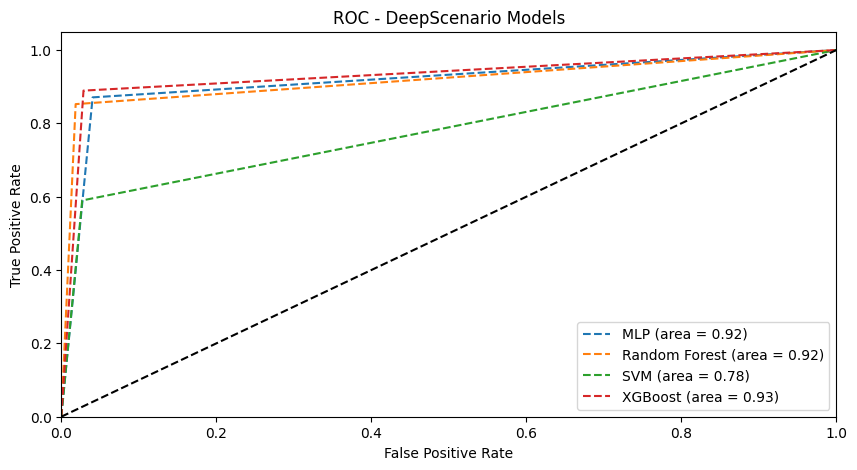

In [63]:
plt.figure(figsize=(10, 5))
plt.plot(mlp_fpr, mlp_tpr, label=f"MLP (area = {mlp_roc_auc:.2f})", linestyle="dashed")
plt.plot(rf_fpr, rf_tpr, label=f"Random Forest (area = {rf_roc_auc:.2f})", linestyle="dashed")
plt.plot(svm_fpr, svm_tpr, label=f"SVM (area = {svm_roc_auc:.2f})", linestyle="dashed")
plt.plot(xgb_fpr, xgb_tpr, label=f"XGBoost (area = {xgb_roc_auc:.2f})", linestyle="dashed")
plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC - DeepScenario Models")
plt.legend(loc="lower right")
plt.show()